In [83]:
#importamos los paquetes necesarios
import torch #contiene todas las funciones de PyTorch
import torch.nn as nn #contiene la clase padre de todos los modelos (nn.Module)
import torch.nn.functional as F #esencial para la función de activación 
import torchvision #fundamental para la importación de imágenes
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
#importamos también matplotlib.pyplot y numpy para la visualización de las imágenes
import matplotlib.pyplot as plt
import numpy as np
import os

In [11]:
#es necesario incluir la siguiente línea para que no se produzcan errores en la representación de las imágenes (entran en conflicto algunos ficheros de matplotlib con los de PyTorch sino)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [56]:
#establecemos el tamaño del batch y la escala de las imágenes
batch = 4
escala = 640

In [57]:
#a continuación definimos la operación que permitirá transformar las imágenes del repositorio en Tensores que puedan ser empleados por PyTorch
transform = transforms.Compose(
    [transforms.ToTensor(), #transforma la imagen de formato PIL a formato tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normaliza el tensor para que la media de sus valores sea 0 y su desviación estándar 0.5
     transforms.Resize((escala, escala))]) 

In [58]:
#a continuación cargamos el conjunto de imágenes de train (OCT) y los dos de test (iPhone y Samsung)
OCT = ImageFolder(root = 'Datos/Processed Data/OCT', transform = transform)
print(f'Tamaño del conjunto de datos de train: {len(OCT)}')

Samsung = ImageFolder(root = 'Datos/Processed Data/Samsung', transform = transform)
print(f'Tamaño del conjunto de datos de test de Samsung: {len(Samsung)}')

iPhone = ImageFolder(root = 'Datos/Processed Data/iPhone', transform = transform)
print(f'Tamaño del conjunto de datos de test de iPhone: {len(iPhone)}')

Tamaño del conjunto de datos de train: 113
Tamaño del conjunto de datos de test de Samsung: 93
Tamaño del conjunto de datos de test de iPhone: 99


In [59]:
#establecemos una lista con el nombre de las etiquetas
classes = OCT.classes

In [60]:
#y definimos también las funciones que van a ir cargando las imágenes en el modelo
train_loader = DataLoader(
    dataset = OCT,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 4, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

test_S_loader = DataLoader(
    dataset = Samsung,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 10, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

test_i_loader = DataLoader(
    dataset = iPhone,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 10, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

In [75]:
#para comprobar que los loaders funcionan correctamente vamos a probar a cargar las imágenes y mostrarlas
#convertimos el train_loader a iterador, para poder así coger un batch
#el batch está compuesto por una tupla de 2 elementos: las imágenes (tensores en este caso) y las etiquetas asociadas
images, labels = next(iter(train_loader))

IMÁGENES DEL CONJUNTO DE TRAIN


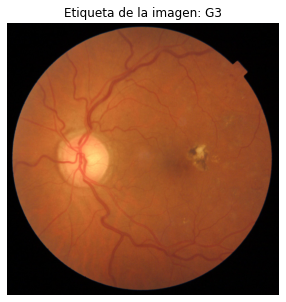

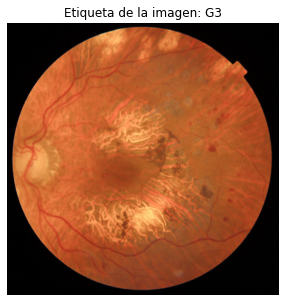

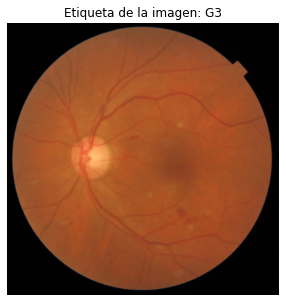

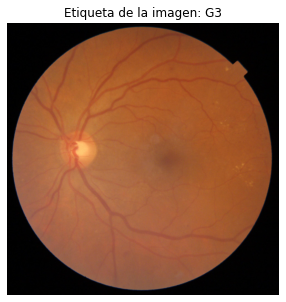

In [77]:
#mostramos las imágenes y las labels asociadas
print('IMÁGENES DEL CONJUNTO DE TRAIN')
for i,j in zip(images,labels):
    plt.figure(figsize = (5,5))
    plt.axis('off')
    plt.title(f'Etiqueta de la imagen: {classes[j]}')
    plt.imshow(np.transpose((i/2+0.5).numpy(), (1,2,0)))
    plt.show()

In [79]:
#hacemos el mismo proceso con las imágenes de test de iPhone
images, labels = next(iter(test_i_loader))

IMÁGENES DEL TEST IPHONE


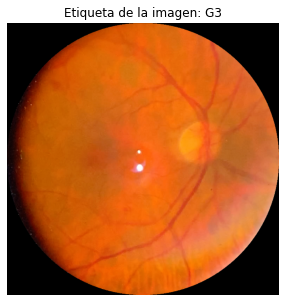

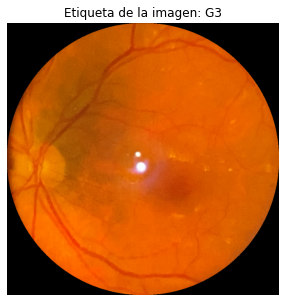

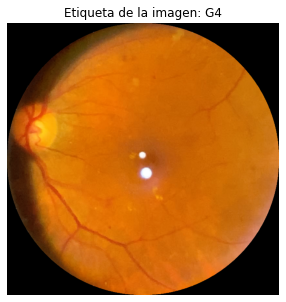

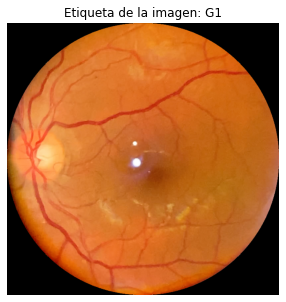

In [80]:
#mostramos las imágenes y las labels asociadas
print('IMÁGENES DEL TEST IPHONE')
for i,j in zip(images,labels):
    plt.figure(figsize = (5,5))
    plt.axis('off')
    plt.title(f'Etiqueta de la imagen: {classes[j]}')
    plt.imshow(np.transpose((i/2+0.5).numpy(), (1,2,0)))
    plt.show()

In [81]:
#y con el conjunto de imágenes de test de Samsung
images, labels = next(iter(test_S_loader))

IMÁGENES DEL TEST SAMSUNG


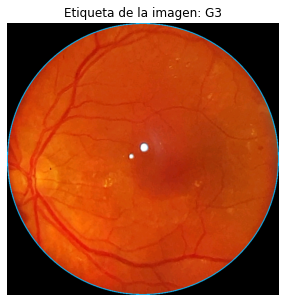

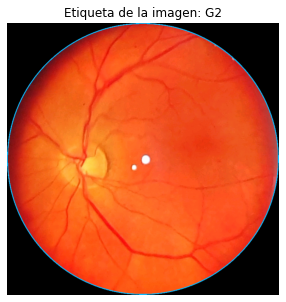

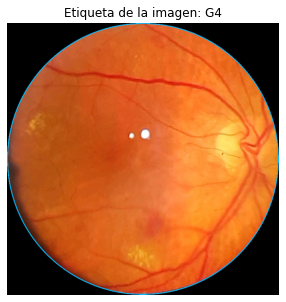

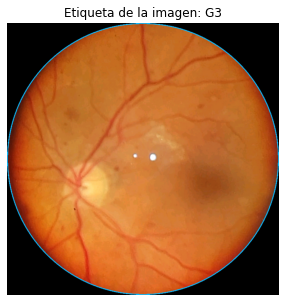

In [82]:
#mostramos las imágenes y las labels asociadas
print('IMÁGENES DEL TEST SAMSUNG')
for i,j in zip(images,labels):
    plt.figure(figsize = (5,5))
    plt.axis('off')
    plt.title(f'Etiqueta de la imagen: {classes[j]}')
    plt.imshow(np.transpose((i/2+0.5).numpy(), (1,2,0)))
    plt.show()

In [98]:
#una vez que hemos comprobado que las funciones de carga funcionan correctamente ya podemos definir el modelo
#los modelos se definen como clases que heredan todos ellos de un mismo padre: nn.Module
#las clases contienen 2 funciones básicas: __init__() y forward()
class CNN(nn.Module):
    
    def __init__(self):
        #esta función sobreescribe la función init() del padre
        super(CNN,self).__init__()
        #definimos todas las capas que van a constituir el modelo
        #una primera capa convolucional
        self.conv1 = nn.Conv2d(
            in_channels = 3, #3 canales de entrada porque las imágenes son a color
            out_channels = 6, #se trata del número de salidas de la capa. Puede tratarse de un valor arbitrario
            kernel_size = 5, #suele tratarse de un número impar
            stride = 1, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 0, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        #una segunda capa convolucional
        self.conv2 = nn.Conv2d(
            in_channels = 6, #6 canales de entrada porque es el número de salidas de la capa anterior
            out_channels = 16, #se trata del número de salidas de la capa. Puede tratarse de un valor arbitrario
            kernel_size = 5, #suele tratarse de un número impar
            stride = 1, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 0, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #una primera capa fully-connected (red neuronal propiamente dicha)
        self.fc1 = nn.Linear(
            in_features = 16*157*157, #número de parámetros de entrada de la red (los valores se obtienen experimentalmente)
            out_features = 120 #número de neuronas de salida
        )
        
        #una segunda fully-connected
        self.fc2 = nn.Linear(120, 84)
        
        #y una tercera. Nótese que el número de neuronas de salida de la última fully-connected ha de coincidir con el número de clases
        self.fc3 = nn.Linear(84,5)
        
    def forward(self,x):
        #en esta función es donde tiene lugar la computación (y la función invocada por defecto al ejecutar la red)
        #primero aplicamos la función ReLU a la capa convolucional, que simplifica los datos. 
        #ReLU Interpreta los valores positivos como son, y los negativos los torna 0, permitiendo acelerar el entrenamiento
        #al resultado le aplicamos MaxPooling que reduce las dimensiones de los datos, seleccionando el valor máximo del kernel.
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size = 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = 2)
        #aplanamos la salida, hasta convertirla de forma matricial a forma vectorial (sería la capa flatten)
        x = x.view(-1,self.num_flat_features(x))#usamos una función propia de la clase para obtener el número de características
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #no incluimos una capa de LogSoft, que convierte el output en probabilidad, ya que la función loss que usaremos incluye esta funcionalidad
        return x
    
    def num_flat_features(self,x):
        #por último definimos la función que permite obtener el número de características de los tensores
        size = x.size()[1:] #seleccionamos todas las dimensiones expcepto la primera (que son los batches)
        num_features = 1
        for s in size:
            num_features*=s
        return num_features

In [99]:
#una vez definida la clase generamos una instancia de la misma
cnn = CNN()
#y mostramos por pantalla sus secciones
print(cnn)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=394384, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)
